In [1]:
import matplotlib.pyplot as plt
from custom_scalar_formatter import CustomScalarFormatter
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import os

In [2]:
def load_results_opt(results_dir, dataset, opt):
    results = {}

    optimizer = opt['optimizer']
    if 'precond' in list(opt.keys()):
        preconditioner = opt['precond']
        results_dir = os.path.join(results_dir, dataset, optimizer, preconditioner)
    else:
        results_dir = os.path.join(results_dir, dataset, optimizer)

    filenames = os.listdir(results_dir)

    if optimizer in ['sgd', 'saga']:
        for filename in filenames:
            if filename.endswith('.csv'):
                if filename.startswith('lr'):
                    start = filename.find('_') + len('_')
                    end = filename.find('_seed_')
                    hyperparam = filename[start:end] # Get lr or L                    
                    df = pd.read_csv(os.path.join(results_dir, filename))
                    results[hyperparam] = df # assumes that we only perform one run per hyperparam
                elif filename.startswith('auto'):
                    df = pd.read_csv(os.path.join(results_dir, filename))
                    results['auto'] = df # assumes that we only perform one run per hyperparam
    elif optimizer in ['sketchysgd']:
        for filename in filenames:
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(results_dir, filename))
                results['auto'] = df # assumes that we only perform one run per hyperparam

    return results

In [3]:
def get_best_run_opt(opt_results, opt_name, metric):
    best_run = None
    best_hyperparam = None

    for hyperparam in list(opt_results.keys()):
        if best_run is None:
            best_run = opt_results[hyperparam]
            if opt_name in ['sgd', 'saga']:
                best_hyperparam = hyperparam
        else:
            if 'loss' in metric:
                if np.min(opt_results[hyperparam][metric].values) < np.min(best_run[metric].values):
                    best_run = opt_results[hyperparam]
                    if opt_name in ['sgd', 'saga']:
                        best_hyperparam = hyperparam
            elif 'acc' in metric:
                if np.max(opt_results[hyperparam][metric].values) > np.max(best_run[metric].values):
                    best_run = opt_results[hyperparam]
                    if opt_name in ['sgd', 'saga']:
                        best_hyperparam = hyperparam
    
    return best_run, best_hyperparam

In [4]:
def get_results(results_dir, dataset, opts, auto_only):
    opt_results = {}
    for opt in opts:
        if isinstance(opt, tuple):
            opt_dict = {'optimizer': opt[0], 'precond': opt[1]}
        else:
            opt_dict = {'optimizer': opt}
        opt_data = load_results_opt(results_dir, dataset, opt_dict)
        if auto_only: # Only plot the auto hyperparameter results if requested
            if 'auto' in list(opt_data.keys()): # If auto hyperparameter results exist, extract them
                opt_results[opt] = {'auto': opt_data['auto']}
        else:
            if opt_dict['optimizer'] in ['sgd', 'saga'] and 'auto' in list(opt_data.keys()): # If we do not care about auto results, remove them
                del opt_data['auto']
            opt_results[opt] = opt_data

    return opt_results

In [5]:
def get_opt_precond_name(opt):        
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None

    return opt_name, precond_name

In [6]:
def print_best_hyperparam(best_hyperparam, opt_name):
    best_hyperparam_str = str(best_hyperparam)
    if opt_name in ['sgd', 'saga']:
        print(f"{opt_name}: best LR = {best_hyperparam_str}")

In [7]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name == 'sketchysgd':
        linestyle = 'dashed'
        marker = markers[precond_name]
        color = colors[(opt_name, precond_name)]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'solid'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]
    
    return linestyle, marker, color, label

In [8]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [9]:
def plot_opt_curve(opt_results, opt, key, best_hyperparam, xaxis, metric, color, linestyle, marker, axes):
    if opt in ['sgd', 'saga'] and key != best_hyperparam:
        alpha = 0
    else:
        alpha = 1

    if xaxis['name'] == 'time':
        x = np.cumsum(opt_results[opt][key]['times'].values) - np.cumsum(opt_results[opt][key]['data_upd_times'].values)
    elif xaxis['name'] == 'epochs':
        x = np.arange(len(opt_results[opt][key]['times'])) + 1

    if 'loss' in metric['name']:
        axes.semilogy(x, opt_results[opt][key][metric['name']], color = color, alpha = alpha, linestyle = linestyle, marker = marker)
    else:
        axes.plot(x, opt_results[opt][key][metric['name']], color = color, alpha = alpha, linestyle = linestyle, marker = marker)

In [10]:
def format_plot(dataset, ylims, xaxis, metric, opt_times_sorted, axes):
    axes.set_title(dataset, fontsize=14)
    axes.set_ylim(ylims)

    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xaxis['label'], fontsize=14)
    axes.set_ylabel(metric['label'], fontsize=14)

    if 'loss' in metric['name']:
        y_lower_bound, y_upper_bound = axes.get_ylim()
        axes.set_yticks([y_lower_bound, y_upper_bound])

        formatter = CustomScalarFormatter(useMathText=True, useOffset=False)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        axes.yaxis.set_major_formatter(formatter)

        minor_ticks = np.linspace(y_lower_bound, y_upper_bound, num=10)
        minor_ticks = minor_ticks[1:-1]
        axes.set_yticks(minor_ticks, minor=True)
        # axes.yaxis.set_minor_formatter(formatter)
        axes.yaxis.set_minor_formatter(NullFormatter())

    if xaxis['name'] == 'time': # Truncate x-axis if plotting wall-clock time
        axes.set_xlim([0, opt_times_sorted[1]])

In [11]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [12]:
def plot_results_metric(results_dir, dataset, opts, metric, colors, opt_plot_names,
                         precond_plot_names, markers, xaxis, ylims, auto_only):
    opt_results = get_results(results_dir, dataset, opts, auto_only)

    fig = plt.figure()
    axes = plt.gca()
    opt_times = np.zeros(len(list(opt_results.keys())))
    legend_elements = get_legend(opt_results.keys(), markers, colors, opt_plot_names, precond_plot_names)
    for i, opt in enumerate(list(opt_results.keys())):
        opt_name, precond_name = get_opt_precond_name(opt)
        
        _, best_hyperparam = get_best_run_opt(opt_results[opt], opt_name, metric['name'])
        print_best_hyperparam(best_hyperparam, opt_name)

        linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

        opt_time = np.inf
        for key in opt_results[opt].keys():
            plot_opt_curve(opt_results, opt, key, best_hyperparam, xaxis, metric, color, linestyle, marker, axes)

            # Get the smallest time taken by the optimization algorithm across all hyperparameters
            opt_time = min(opt_time, np.sum(opt_results[opt][key]['times'].values - opt_results[opt][key]['data_upd_times'].values))
        opt_times[i] = opt_time
    opt_times_sorted = np.sort(opt_times)

    plt.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=14)
    format_plot(dataset, ylims, xaxis, metric, opt_times_sorted, axes)

    fig_name = f"{dataset}_{xaxis['name']}.pdf"
    directory = './streaming_'+ ('auto' if auto_only else 'tuned') + '/' + metric['name']
    save(directory, fig_name, fig)

In [13]:
def plot_results_metric_xaxes(results_dir, data_params, xaxes, opts, metric, colors, opt_plot_names,
                              precond_plot_names, markers, auto_only):
    # each element of data_params is dictionary with keys 'dataset', 'ylims'
    # create a grid of plots, one for each dataset and x-axis
    n_datasets = len(data_params)
    n_xaxes = len(xaxes)
    fig, axes = plt.subplots(nrows = n_datasets, ncols = n_xaxes, figsize=(5*n_xaxes, 4*n_datasets))

    for i, data_param in enumerate(data_params):
        dataset = data_param['dataset']
        ylims = data_param['ylims']
        for j, xaxis in enumerate(xaxes):
            # subplot_idx = i * n_datasets + (n_xaxes - j - 1)
            subplot_idx = i * n_datasets + j

            opt_results = get_results(results_dir, dataset, opts, auto_only)
            opt_times = np.zeros(len(list(opt_results.keys())))
            if i == 0 and j == 0: # Only compute legend once
                legend_elements = get_legend(opt_results.keys(), markers, colors, opt_plot_names, precond_plot_names)
            for k, opt in enumerate(list(opt_results.keys())):
                opt_name, precond_name = get_opt_precond_name(opt)
                _, best_hyperparam = get_best_run_opt(opt_results[opt], opt_name, metric['name'])

                linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
                
                opt_time = np.inf
                for key in opt_results[opt].keys():
                    plot_opt_curve(opt_results, opt, key, best_hyperparam, xaxis, metric, color, linestyle, marker, axes.flat[subplot_idx])

                    # Get the smallest time taken by the optimization algorithm across all hyperparameters
                    opt_time = min(opt_time, np.sum(opt_results[opt][key]['times'].values - opt_results[opt][key]['data_upd_times'].values))
                opt_times[k] = opt_time
            opt_times_sorted = np.sort(opt_times)
            format_plot(dataset, ylims, xaxis, metric, opt_times_sorted, axes.flat[subplot_idx])
    
    for ax in axes.flat:
        ax.set_ylabel('') # Turn off y-labels for subplots
    fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)

    fig.tight_layout(pad = 2.0)

    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=len(opts), fontsize=14)

    # Save plot
    directory = './streaming_'+ ('auto' if auto_only else 'tuned') + '/' + metric['name']
    fig_name = f"{dataset}_combined.pdf"
    save(directory, fig_name, fig)

In [14]:
results_dir = '../simods_streaming_results'
opts = ['sgd', 'saga', ('sketchysgd', 'nystrom'), ('sketchysgd', 'ssn')]
metrics = [{'name': 'test_loss', 'label': 'Test Loss'},
        {'name': 'test_acc', 'label': 'Test Accuracy (\%)'}]
colors = {'sgd': 'tab:red', 'saga': 'tab:orange', ('sketchysgd', 'nystrom'): 'tab:green', ('sketchysgd', 'ssn'): 'tab:purple'}
opt_plot_names = {'sgd': 'SGD', 'saga': 'SAGA', 'sketchysgd': 'SketchySGD'}
precond_plot_names = {'nystrom': r'Nystr$\ddot{\mathrm{o}}$m', 'ssn': 'SSN'}
markers = {'nystrom': '^', 'ssn': '*'}
xaxes = [{'name': 'time', 'label': 'Wall-clock time (s)'}, {'name': 'epochs', 'label': 'Epochs'}]

In [15]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

### All tuned

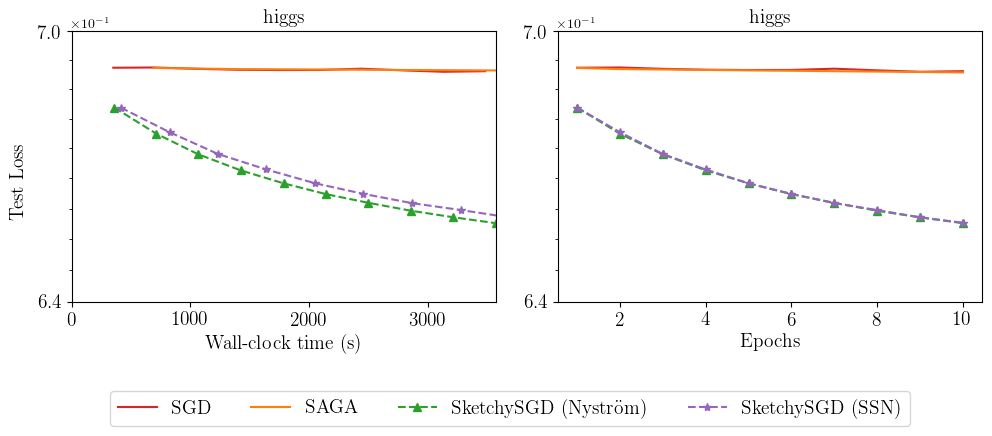

In [16]:
data_params = [{'dataset': 'higgs', 'ylims': [6.4e-1, 7e-1]}]

# Test loss
plot_results_metric_xaxes(results_dir, data_params, xaxes, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, auto_only = False)

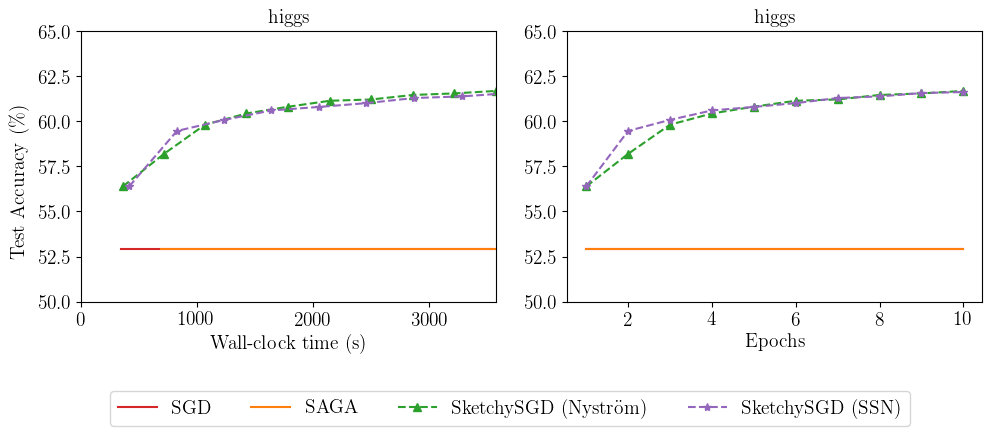

In [17]:
data_params = [{'dataset': 'higgs', 'ylims': [50, 65]}]

# Test accuracy
plot_results_metric_xaxes(results_dir, data_params, xaxes, opts, metrics[1], colors, opt_plot_names, precond_plot_names, markers, auto_only = False)

### All auto

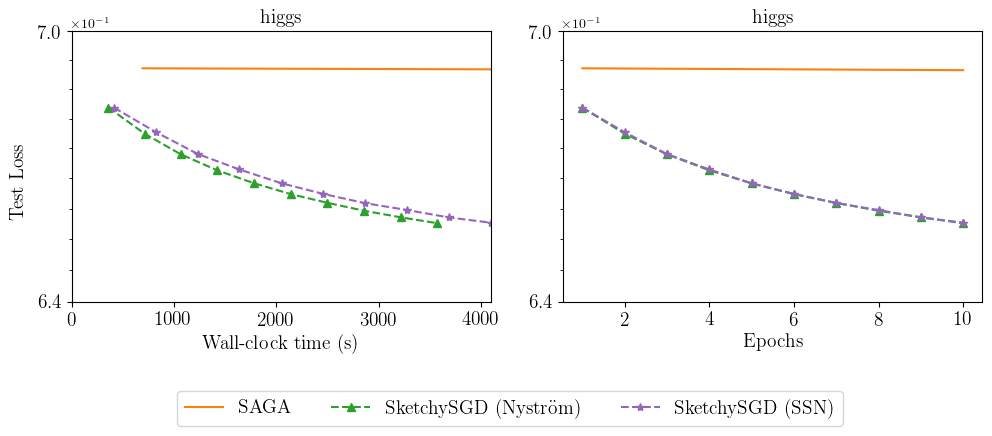

In [18]:
data_params = [{'dataset': 'higgs', 'ylims': [6.4e-1, 7e-1]}]

# Test loss
plot_results_metric_xaxes(results_dir, data_params, xaxes, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, auto_only = True)

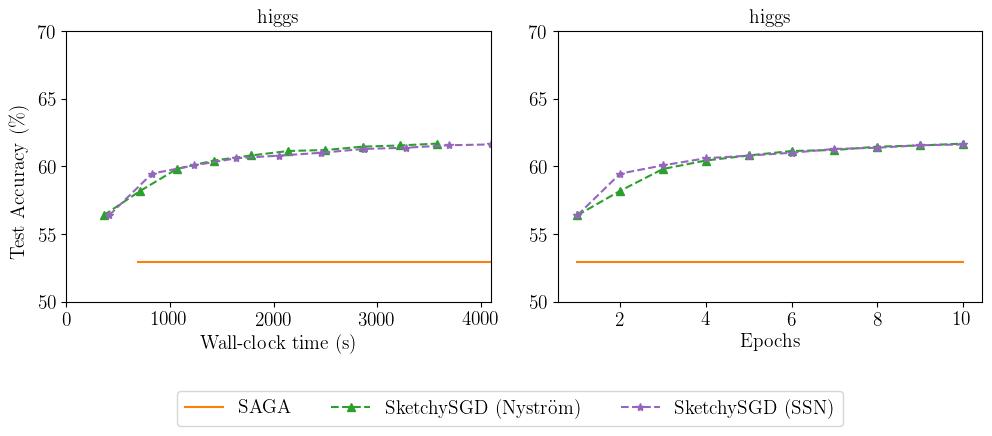

In [19]:
data_params = [{'dataset': 'higgs', 'ylims': [50, 70]}]

# Test accuracy
plot_results_metric_xaxes(results_dir, data_params, xaxes, opts, metrics[1], colors, opt_plot_names, precond_plot_names, markers, auto_only = True)

### higgs

In [20]:
# dataset = 'higgs'
# ylims = [6.4e-1, 7e-1]
# auto_only = False
# plot_results_metric(results_dir, dataset, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_results_metric(results_dir, dataset, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### higgs - auto

In [21]:
# dataset = 'higgs'
# ylims = [6.4e-1, 7e-1]
# auto_only = True
# plot_results_metric(results_dir, dataset, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_results_metric(results_dir, dataset, opts, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)